In [2]:
import sys
parent_path = "/home/jan/Documents/masterthesis/project/mucus"
sys.path.append(parent_path)

import numpy as np
import matplotlib.pyplot as plt
from polymer.polymer import Polymer
from polymer.config import Config
from numba import njit

steps=10000 stride=50 number_of_beads=120 nbeads=10 nchains=12 mobility=5e-05 rbead=1.0 qbead=2.08 force_constant=100.0 epsilon_LJ=0.25 sigma_LJ=2.0 cutoff_LJ=2.0 lB_debye=3.077 c_S=10.0 cutoff_debye=4.0 lbox=20.0 pbc=True cutoff_pbc=4.0 save_traj=True write_traj=True cwd='/home/jan/Documents/masterthesis/project/mucus/test_skripts' fname_traj='/storage/janmak98/masterthesis/trajectories/box/test/traj_test_box_10_12_0.gro' fname_sys='/home/janmak98/mucus/configs/cfg_test_box_10_12_0.toml' simulation_time=52.24161148071289 


In [3]:
names_1_wtp = ("315",   # m = 1000 kDa
               "319",   # m = 2000 kDa
               "323")   # m = 4000 kDa

names_2_wtp = ("316",   # m = 1000 kDa
               "320",   # m = 2000 kDa
               "324")   # m = 4000 kDa

names_3_wtp = ("317",   # m = 1000 kDa
               "321",   # m = 2000 kDa
               "325")   # m = 4000 kDa

names_4_wtp = ("318",   # m = 1000 kDa
               "322",   # m = 2000 kDa
               "326")   # m = 4000 kDa

names = (names_1_wtp, names_2_wtp, names_3_wtp, names_4_wtp)

In [21]:
# calculate simulated structure factor

# load trajectory into Polymer object
fname_cfg = "/home/jan/Documents/masterthesis/project/mucus/configs/sys_120beeds_20.00lbox_0.00005mu_v2.toml"
cfg = Config.from_toml(fname_cfg)
fname_traj = "/home/jan/Documents/masterthesis/project/mucus/trajectories/traj_120beeds_201frames_0.00005mu_v2.gro"
p = Polymer(cfg)
p.load_traj_gro(fname_traj,overwrite=True)

#p.get_structure_factor(q=q)

In [19]:
# #make q dependent on lambda
# lam = np.linspace(0.5, 100, 300) # wavelength in reduced units
# n = 1.1 # refractive index
# theta = 0.005 #scattering angle
# q = 4*np.pi*n/lam * np.sin(theta/2)

q = np.linspace(1e-3, 1e-1, 100)
q = np.array(q)
        

trajectory = p.trajectory[:100000]
n_beeds = p.n_beeds
@njit
def S_q(trajectory, q, n_beeds):
    structure_factor = np.zeros(len(q))
    for frame in trajectory:
        for i in range(n_beeds-1):
            for j in range(i+1, n_beeds):
                r = frame[j] - frame[i] 
                qr = q*np.sqrt(np.dot(r, r))
                structure_factor += np.sin(qr)/qr

    #factor 2 because of double sum reduction from i,j to i<j
    structure_factor = structure_factor*2/n_beeds**2/len(trajectory)
    return structure_factor

Sq = S_q(trajectory, q, n_beeds)

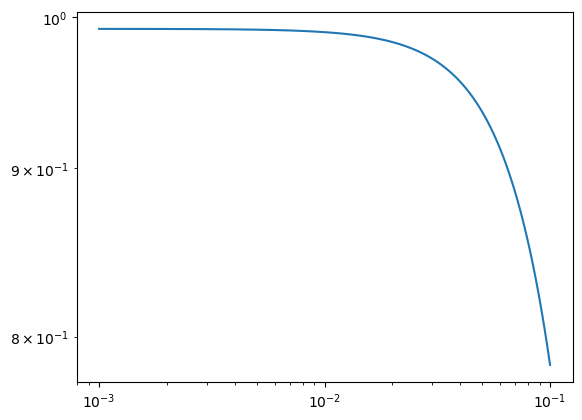

In [20]:
plt.figure()
plt.loglog()
plt.plot(q, Sq)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (100,) and (300,)

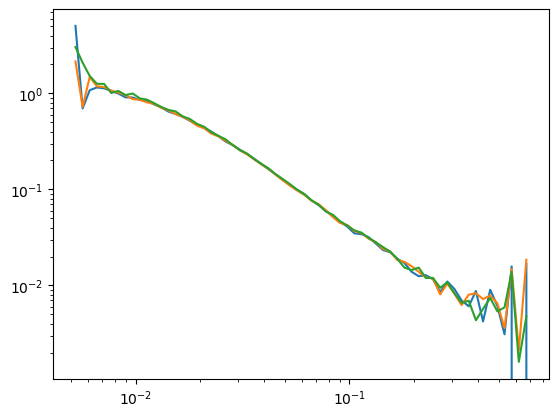

In [20]:
mass = (1000, 2000, 4000)

for k, name_group in enumerate(names):
    
    plt.figure()
    for idx_m, name in enumerate(name_group):
        # if idx_m == 2: # exclude 4000 for now
        #     break
        fname = f"/home/jan/Documents/masterthesis/project/mucus/exp_data/sans_nov22_PEG/RS22-{name:s}_rear_1D_0.9_13.5.txt"
        data = np.loadtxt(fname, skiprows=5)
        plt.loglog()
        
        plt.plot(data[:,0], data[:,1], label=f"{mass[idx_m]:d} kDa, x")
        #plt.plot(data[:,0], data[:,2], label=f"{mass[idx_m]:d} kDa, y")
        #plt.plot(data[:,0], data[:,3], label=f"{mass[idx_m]:d} kDa, z")
    plt.plot(q, p.structure_factor/1e8, label="sim")
    plt.xlim((0.005, 0.2))
    plt.legend()
    plt.title(f"{k+1:d} wt%")
    plt.show()